# Exploratory Data Analysis

The porpuse of this notebooks is describe all the content in the provided data to predict **Obesity Risk**.

## Required Imports

In [22]:
import os
import pickle
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from prettytable import PrettyTable
from dash import Dash, dcc, html, Input, Output

In [23]:
warnings.filterwarnings("ignore")

## Constants Defintion

In [24]:
DATA_PATH = '../../data/'
RAW_PATH = DATA_PATH + 'raw/'
INTERMID_PATH = DATA_PATH + 'intermid/'
RESULTS_PATH = '../../results/'

## Data Load

Initially the provided data is splitted in two datasets: *train* and *test*, but for analysis porpouses those will be stacked in one dataframe despite the *test* dataset does not have the ``NObeyesdad`` column.

In [25]:
train_df = pd.read_csv(RAW_PATH + 'train.csv')
test_df = pd.read_csv(RAW_PATH + 'test.csv')

print('Size of train set:', len(train_df))
print('Size of test set:',len(test_df))

Size of train set: 20758
Size of test set: 13840


In [26]:
stacked_df = pd.concat([train_df, test_df])
print('Size of whole set:',len(stacked_df))

Size of whole set: 34598


In [27]:
stacked_df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


## Data Analysis

First of all we have to review the data types of all the features in the dataset:

In [28]:
table = PrettyTable()
table.field_names = ['Column Type', 'Column Name', 'Null Values']
table.title = 'Obesity Risk Dataset Columns'

for column in stacked_df.dtypes.index:
    table.add_row([column, stacked_df.dtypes[column], stacked_df[column].isna().sum()])

print(table)

+------------------------------------------------------------+
|                Obesity Risk Dataset Columns                |
+--------------------------------+-------------+-------------+
|          Column Type           | Column Name | Null Values |
+--------------------------------+-------------+-------------+
|               id               |    int64    |      0      |
|             Gender             |    object   |      0      |
|              Age               |   float64   |      0      |
|             Height             |   float64   |      0      |
|             Weight             |   float64   |      0      |
| family_history_with_overweight |    object   |      0      |
|              FAVC              |    object   |      0      |
|              FCVC              |   float64   |      0      |
|              NCP               |   float64   |      0      |
|              CAEC              |    object   |      0      |
|             SMOKE              |    object   |      0

The previous tables shows us two insights:
 
 -  The dataset has no Null or empty values. The 13840 null entries in ``NObeyesdad`` came from the *test* dataset, so for the analysis of the distribution of the data in that column the dataframe that will be used is ``train_df`` and not ``stacked_df``.
 -  As many of the string and boolean columns are being interpreted as ``object``. Is ideal to replace this datatype for an accurate type that fits better for anaylsis and modeling porpuses.

In [29]:
target_column = 'NObeyesdad'
string_columns = ['Gender', 'CAEC', 'CALC', 'MTRANS']
boolean_columns = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

In [30]:
# Replace yes and no values for 1s and 0s in booleans
stacked_df[boolean_columns] = stacked_df[boolean_columns].replace('yes', 1) 
stacked_df[boolean_columns] = stacked_df[boolean_columns].replace('no', 0) 

### Plot Distribution of Categorical Variables

In [31]:
app = Dash(__name__)

app.layout = html.Div([
    html.H4('Obesity Risk Categorical Variables Distribution'),
    dcc.Graph(id="graph"),
    html.P("Variables:"),
    dcc.Dropdown(id='variables',
        options=string_columns,
        value='Gender', clearable=False
    )
])


@app.callback(
    Output("graph", "figure"), 
    Input("variables", "value"))
def generate_chart(variables):
    df = stacked_df[variables].value_counts()
    fig = px.pie(df, values='count', names=df.index, color_discrete_sequence=px.colors.sequential.RdBu)
    return fig


app.run_server()

As we can see, the distribution of most of the categorical variables is not equal, having always an unbalanced class by far. This insight has to be taken on mind at the moment of taking decissions and evaluating the best features for the model. Let see our target variable:

In [32]:
fig2 = px.pie(
    train_df[target_column].value_counts(), 
    values='count', 
    names=train_df[target_column].value_counts().index, 
    color_discrete_sequence=px.colors.sequential.RdBu)

fig2.show()

In this case, the distribution of our target variable ``NObeyesdad`` is well balanced and there is not a thing like a mayority class that can generate a bias in the future models performance.

As next step is necessary to encode all the categorical variables. This process will be repeated at the end of the *EDA* to save the datasets in a manner those are ready for training a model.

In [33]:
# Build categorical encoders
encoders = dict()
for column in string_columns:
    new_encoder = LabelEncoder()
    stacked_df[column] = new_encoder.fit_transform(stacked_df[column])
    encoders[column] = new_encoder

In [34]:
encoders['Gender'].classes_

array(['Female', 'Male'], dtype=object)

### Numercial Data Distribution

Once the overview of the categorical data is completed and a basic processing of it has been made, taking a look at the numerical variables for the dataset is an important part of this EDA.

In [35]:
numerical_columns = list(set(stacked_df.columns) - set(boolean_columns + string_columns + [target_column, 'id']))

In [36]:
numerical_columns

['Age', 'FCVC', 'Height', 'NCP', 'Weight', 'TUE', 'CH2O', 'FAF']

In [37]:
app2 = Dash(__name__)

app2.layout = html.Div([
    html.H4('Obesity Risk Numerical Variables Distribution'),
    dcc.Graph(id="graph_box"),
    html.P("Variables:"),
    dcc.Dropdown(id='variable',
        options=numerical_columns,
        value='Weight', clearable=False
    )
])


@app2.callback(
    Output("graph_box", "figure"), 
    Input("variable", "value"))
def generate_chart_box(variable):
    df = stacked_df
    if variable in ['Age', 'Height', 'Weight']:
        fig = px.box(df, y=variable)
    elif variable in ['NCP', 'FAF', 'TUE', 'CH2O']:
        fig = ff.create_distplot([df[variable].to_list()], [variable], bin_size=.2, colors=['#636EFA'])
    else:
        fig = px.histogram(df, x=variable, nbins=3)
        fig.update_layout(bargap=0.2)
    return fig


app2.run_server()

### Correlation Analysis

As the stacked dataframe contains the null values from the test dataset the correlation analysis will be performed with the train dataset only. To complete the analysis we have to repeat the process of encoding and replacing object values for int representations.

In [38]:
train_df[target_column].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

In [39]:
train_df[boolean_columns] = train_df[boolean_columns].replace('yes', 1) 
train_df[boolean_columns] = train_df[boolean_columns].replace('no', 0)

for column in string_columns:
    encoder = encoders[column]
    train_df[column] = encoder.transform(train_df[column])

train_df[target_column] = train_df[target_column].replace({
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6,
})

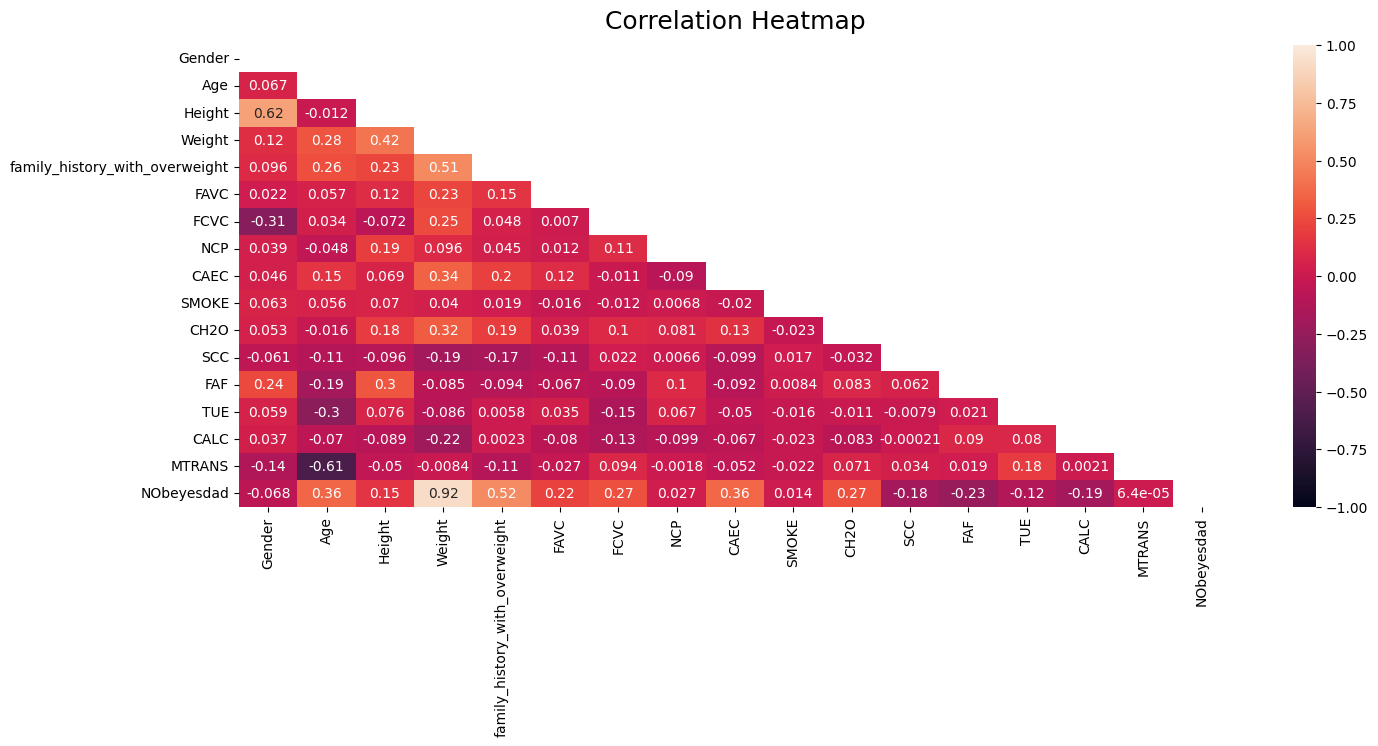

In [40]:
plt.figure(figsize=(16, 6))

mask = np.triu(np.ones_like(train_df[train_df.columns[1:]].corr(), dtype=np.bool))
heatmap = sns.heatmap(train_df[train_df.columns[1:]].corr(), vmin=-1, vmax=1, annot=True, mask=mask)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

This correlation results shows that most of the available features to train a model that will predict ``NObeyesdad`` are not strongly correlated to it (excluding the weight and the family history). It leads us to idea that will be necessary to have an processing step before modeling.

All the processing and feature engineering can be find in ``notebooks/processing/`` folder.

## Save Train Data

As we have been performing some trasnformations over our train dataset, in order to don't repeat those in the processing module it will be stored in a .csv file in the ``data/intermmid/`` to keep the process of building and deploying a model to predict obesity risk.

In [41]:
train_df.to_csv(INTERMID_PATH + 'train.csv', index=False)

## Save Encoders

In [42]:
with open(RESULTS_PATH + '/encoders/' + 'encoders.pkl', 'wb') as file:
    pickle.dump(encoders, file)
    file.close()